In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install shap

import tensorflow as tf
import numpy as np
from pyspark.sql import SparkSession, functions as F
import shap
import zipfile
import os
import json
import matplotlib.pyplot as plt

In [ ]:

# ---------------------
# 1️⃣ Constants
# ---------------------
sequence_length = 12
categorical_index_cols = ["iso3_country_index", "sector_index", "subsector_index", "gas_index"]
numerical_feature_columns = ["lat_scaled", "lon_scaled", "duration_scaled", "start_year_scaled", "start_month_sin", "start_month_cos"]


In [ ]:
# ---------------------
# 2️⃣ Custom layers
# ---------------------
@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super(PositionalEncoding, self).__init__(**kwargs)

    def call(self, inputs):
        return inputs

@tf.keras.utils.register_keras_serializable()
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        return inputs[:, :, self.index]

@tf.keras.utils.register_keras_serializable()
class SqueezeLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.squeeze(inputs, axis=-1)
@tf.keras.utils.register_keras_serializable()
def r2_score(y_true, y_pred):
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + tf.keras.backend.epsilon())

In [ ]:
# ---------------------
# 3️⃣ Load model
# ---------------------
model = tf.keras.models.load_model(
    "/content/drive/MyDrive/XAI/final_transformer_model.keras",
    custom_objects={
        'r2_score': r2_score,
        'PositionalEncoding': PositionalEncoding,
        'SliceLayer': SliceLayer,
        'SqueezeLayer': SqueezeLayer
    }
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer         │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_1       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_2       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ slice_layer_3       │ (None, 12)        │          0 │ input_layer[0][0] │
│ (SliceLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 12, 8)     │        800 │ slice_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 12, 8)     │        800 │ slice_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 12, 8)     │        800 │ slice_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 12, 8)     │        800 │ slice_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 12, 32)    │          0 │ embedding[0][0],  │
│ (Concatenate)       │                   │            │ embedding_1[0][0… │
│                     │                   │            │ embedding_2[0][0… │
│                     │                   │            │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 12, 6)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 12, 38)    │          0 │ concatenate[0][0… │
│ (Concatenate)       │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 12, 64)    │      2,496 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 12, 64)    │          0 │ dense[0][0]       │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 12, 64)    │     66,368 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 12, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 12, 64)    │          0 │ positional_encod

 Total params: 516,485 (1.97 MB)

 Trainable params: 172,161 (672.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 344,324 (1.31 MB)

In [ ]:
import zipfile
import os
from pyspark.sql import SparkSession, functions as F

sequence_length = 12

zip_file_path = '/content/drive/MyDrive/preprocessingForSingleTimeSeries/sequenced_for_single_model.zip'
extract_path = '/content/extracted_data'

if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

spark = SparkSession.builder \
    .appName("GHGEmissionsForecasting") \
    .config("spark.driver.memory", "16g") \
    .config("spark.executor.memory", "16g") \
    .getOrCreate()

full_df = spark.read.parquet(extract_path)

def extract_batch(df, n_samples=10):
    cat_seqs = []
    num_seqs = []
    target_seqs = []

    rows = df.limit(n_samples).collect()

    for row in rows:
        cat_seq = []
        num_seq = []

        for timestep in row["feature_sequence"]:
            cat_features = np.array([
                timestep["iso3_country_index"],
                timestep["sector_index"],
                timestep["subsector_index"],
                timestep["gas_index"]
            ], dtype=np.int32)

            num_features = np.array([
                timestep["lat_scaled"],
                timestep["lon_scaled"],
                timestep["duration_scaled"],
                timestep["start_year_scaled"],
                timestep["start_month_sin"],
                timestep["start_month_cos"]
            ], dtype=np.float32)

            cat_seq.append(cat_features)
            num_seq.append(num_features)

        cat_seqs.append(np.array(cat_seq))
        num_seqs.append(np.array(num_seq))
        target_seqs.append(np.array(row["target_sequence"]))

    return np.array(cat_seqs), np.array(num_seqs), np.array(target_seqs)

test_year = full_df.select("start_year").distinct().orderBy("start_year", ascending=False).collect()[0]['start_year']
test_df = full_df.filter(F.col("start_year") == test_year)

cat_batch, num_batch, target_batch = extract_batch(test_df, n_samples=10)

print("cat_batch shape:", cat_batch.shape)
print("num_batch shape:", num_batch.shape)


cat_batch shape: (10, 12, 4)
num_batch shape: (10, 12, 6)


In [ ]:
num_data = num_batch.reshape((num_batch.shape[0], -1))
print("Numerical data shape for SHAP:", num_data.shape)

Numerical data shape for SHAP: (10, 72)


In [ ]:
def predict_num_only(num_data_flat):
    num_data_reshaped = num_data_flat.reshape((-1, 12, 6))
    cat_data_repeated = np.repeat(cat_batch[:1], repeats=num_data_reshaped.shape[0], axis=0)
    preds = model.predict([cat_data_repeated, num_data_reshaped], verbose=0)
    return preds


In [ ]:
import shap
shap.initjs()

explainer_num = shap.KernelExplainer(
    predict_num_only,
    num_data  # background data for SHAP
)

In [ ]:
shap_values_num = explainer_num.shap_values(num_data, nsamples=100)


  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#  shap_values_num = explainer_num.shap_values(num_data[:3], nsamples=50)

In [ ]:
feature_names = []
for t in range(sequence_length):
    for f in numerical_feature_columns:
        feature_names.append(f"{f}_t{t+1}")


In [ ]:
print(len(feature_names))
print(num_data.shape)

72
(10, 72)


In [ ]:
print("num_data shape:", num_data.shape)
print("shap_values_num shape:", shap_values_num.shape)
print("Number of feature names:", len(feature_names))
print(type(shap_values_num))
print(len(shap_values_num))

num_data shape: (10, 72)
shap_values_num shape: (10, 72, 12)
Number of feature names: 72
<class 'numpy.ndarray'>
10


In [ ]:
# Step 1: Build nice feature names
nice_feature_names = []
for t in range(1, sequence_length + 1):  # Months 1 to 12
    for col in numerical_feature_columns:
        nice_feature_names.append(f"{col} (Month {t})")

print("Total features:", len(nice_feature_names))
print(nice_feature_names[:10])  # Example

Total features: 72
['lat_scaled (Month 1)', 'lon_scaled (Month 1)', 'duration_scaled (Month 1)', 'start_year_scaled (Month 1)', 'start_month_sin (Month 1)', 'start_month_cos (Month 1)', 'lat_scaled (Month 2)', 'lon_scaled (Month 2)', 'duration_scaled (Month 2)', 'start_year_scaled (Month 2)']



📊 SHAP Summary Plot — Month 1



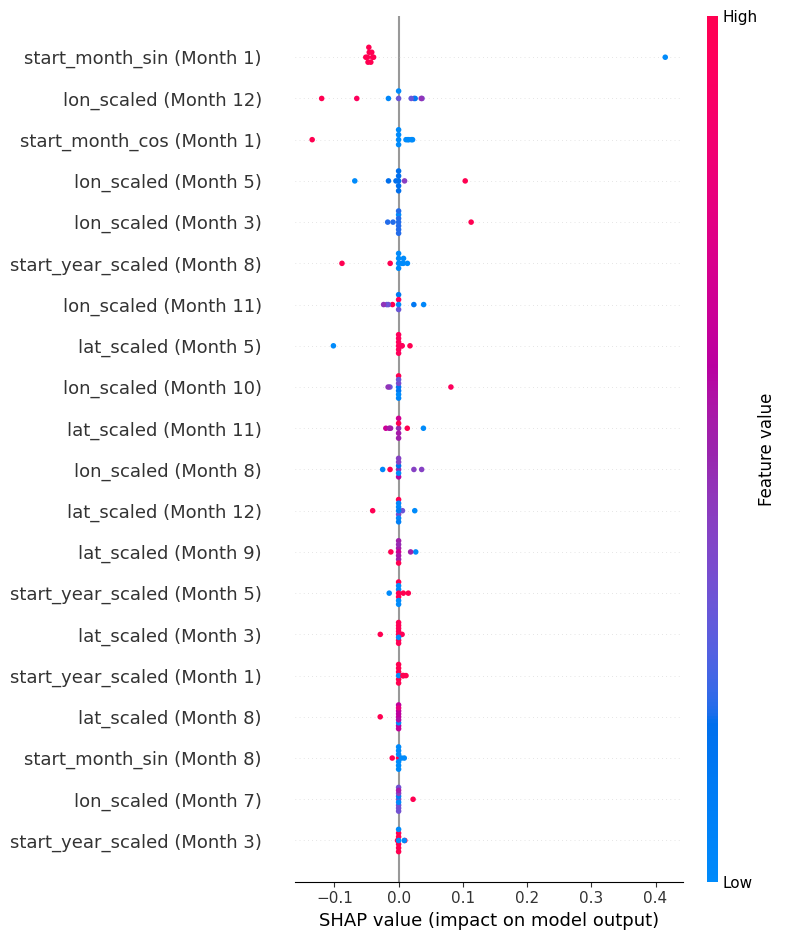


📊 SHAP Summary Plot — Month 2



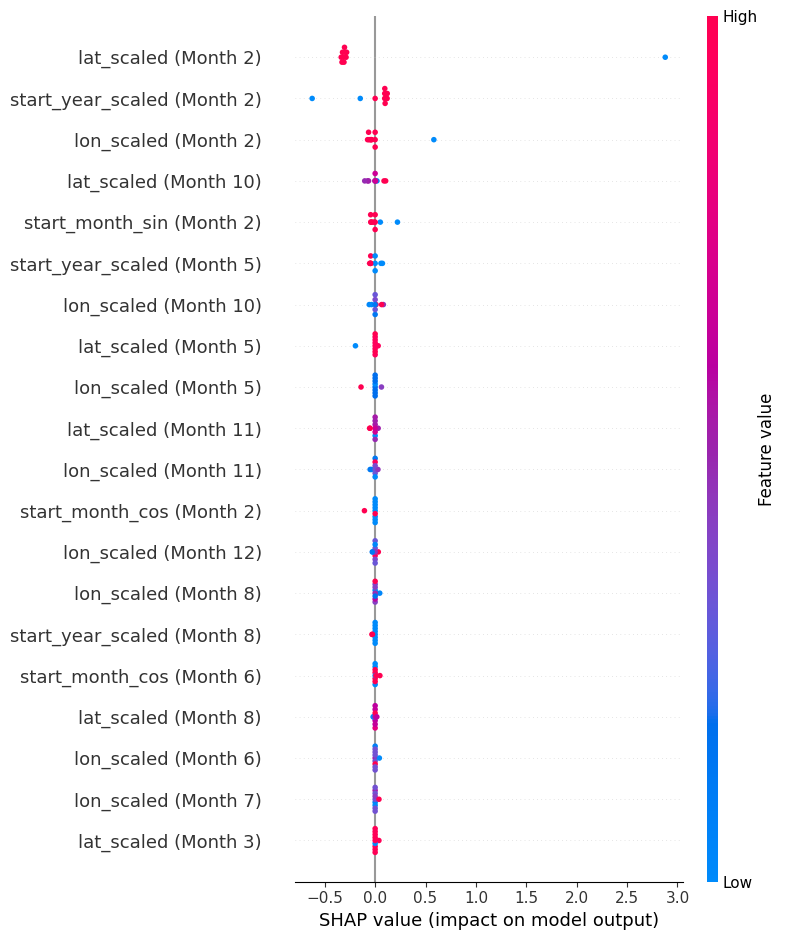


📊 SHAP Summary Plot — Month 3



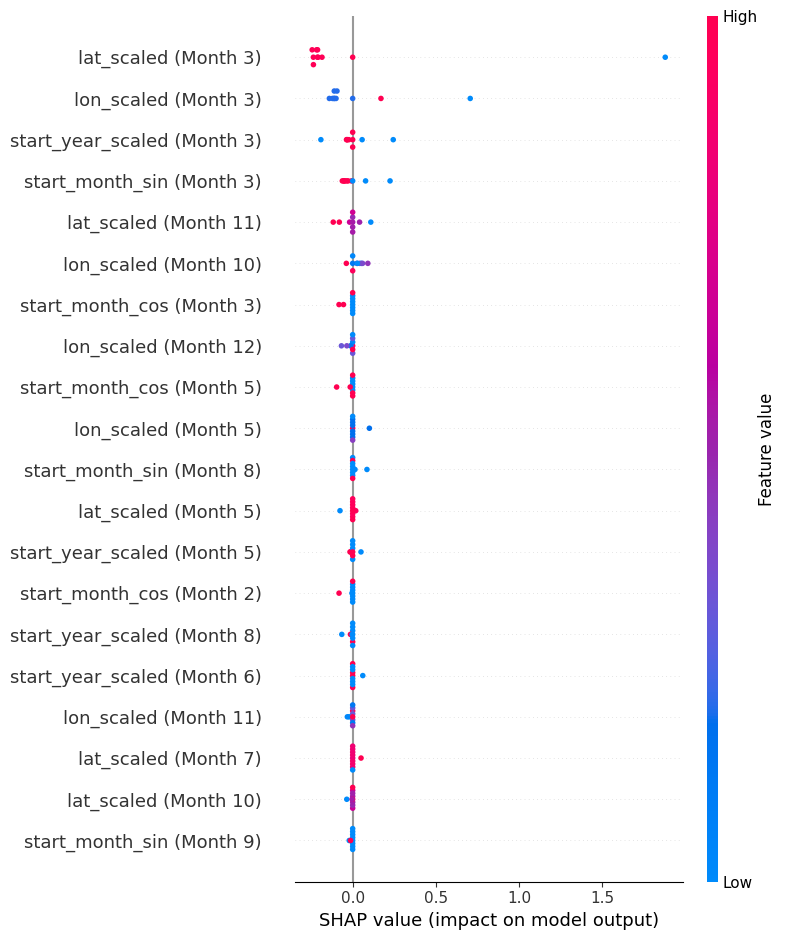


📊 SHAP Summary Plot — Month 4



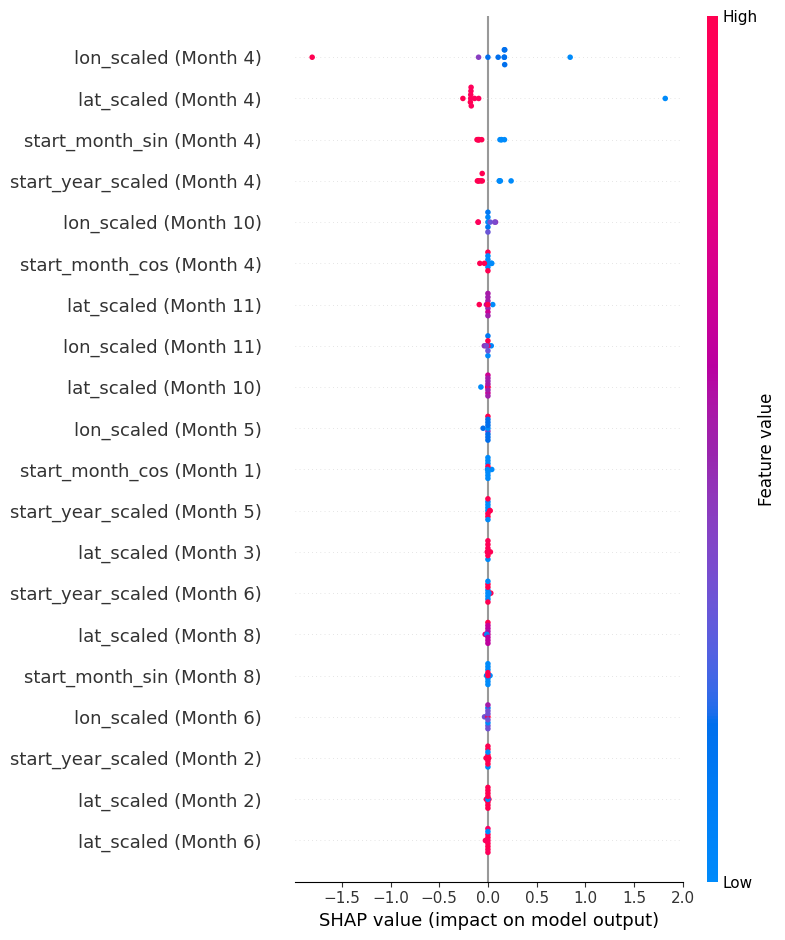


📊 SHAP Summary Plot — Month 5



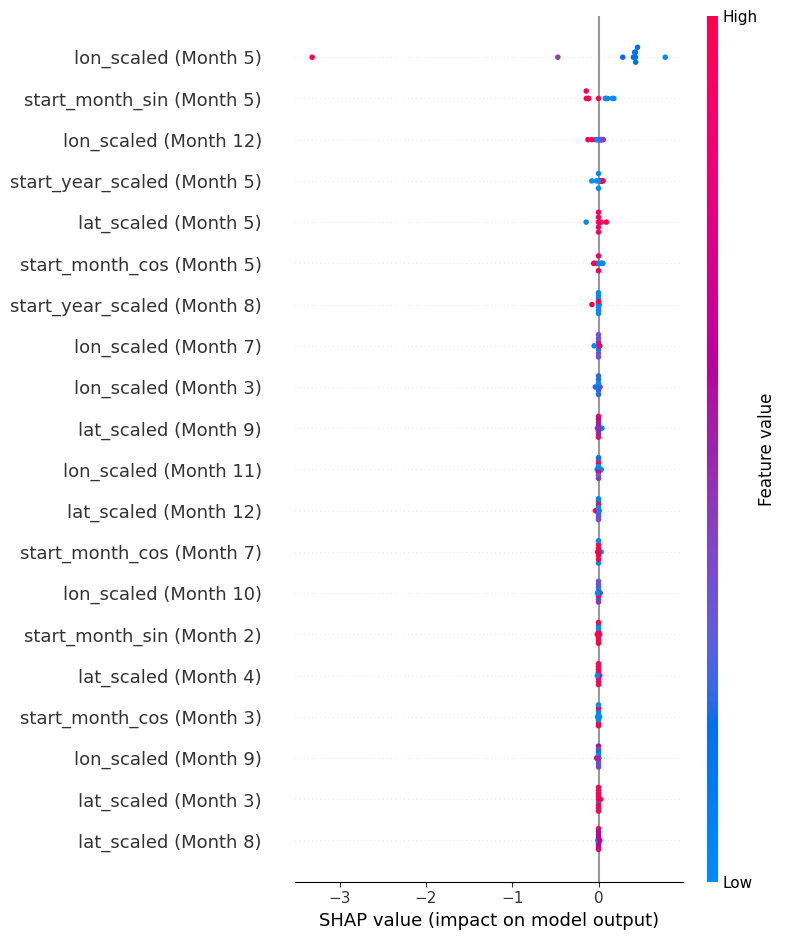


📊 SHAP Summary Plot — Month 6



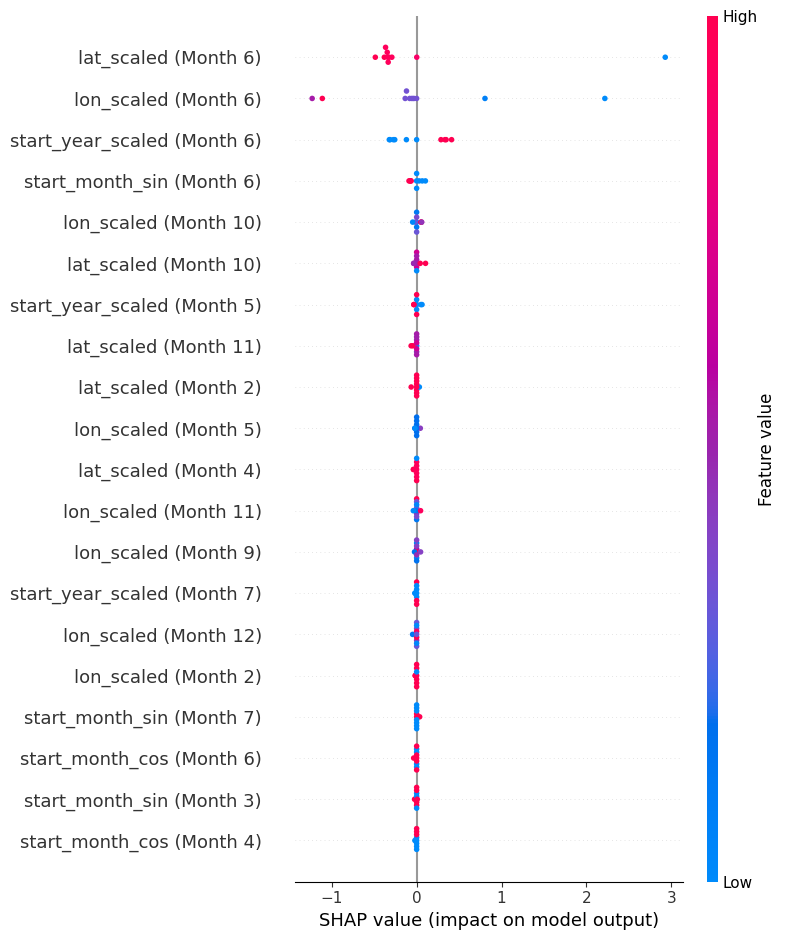


📊 SHAP Summary Plot — Month 7



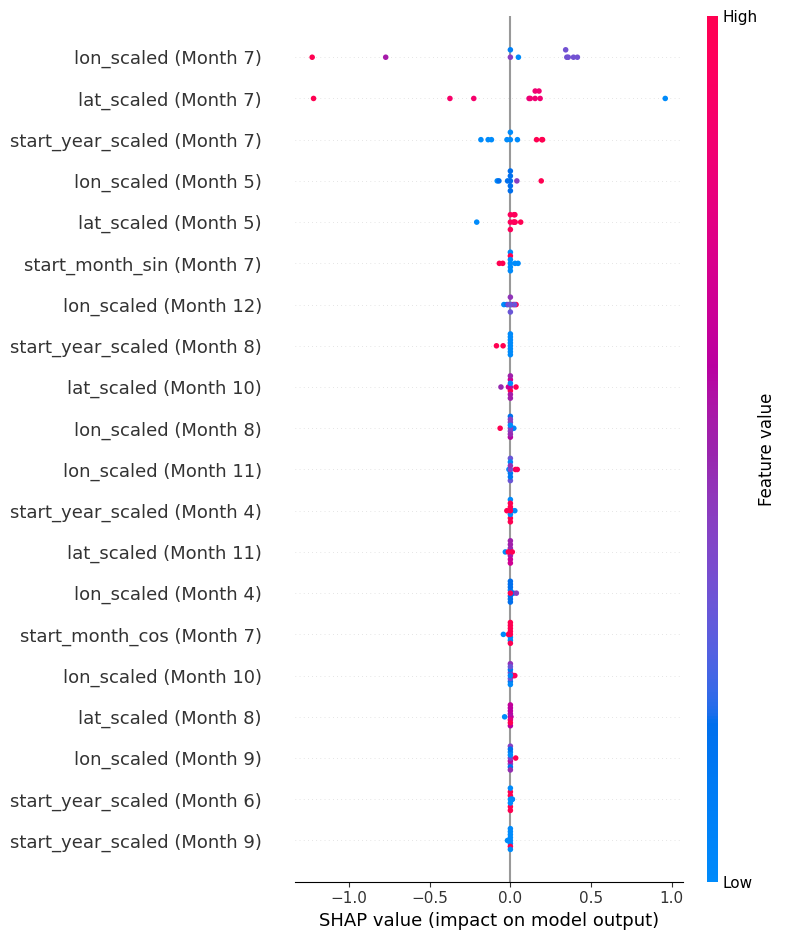


📊 SHAP Summary Plot — Month 8



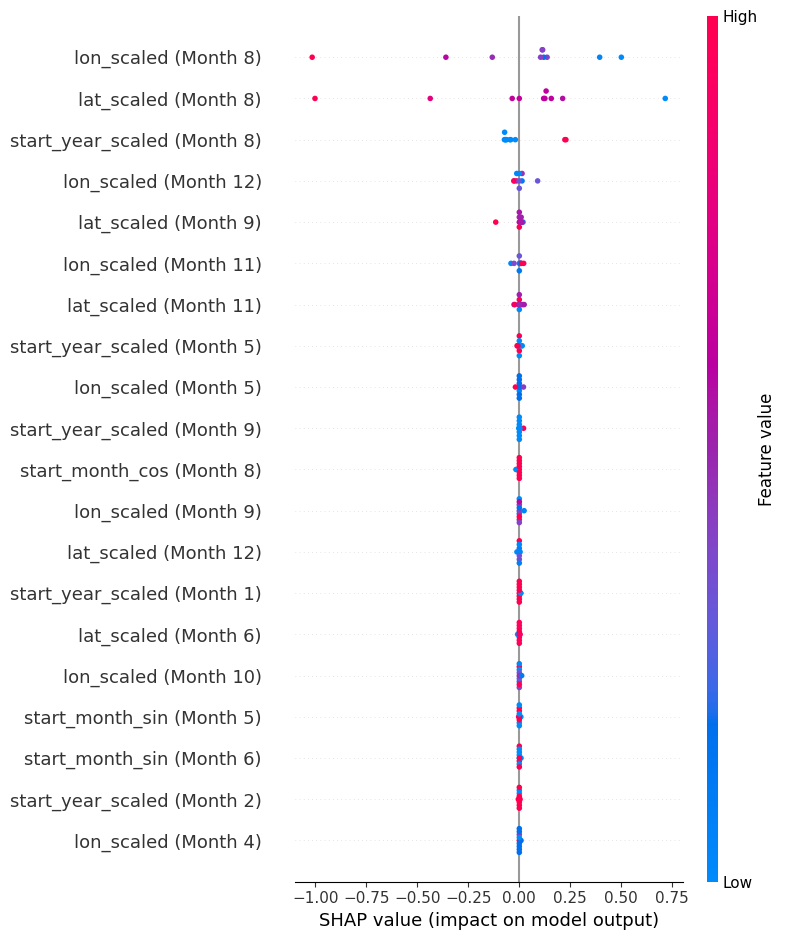


📊 SHAP Summary Plot — Month 9



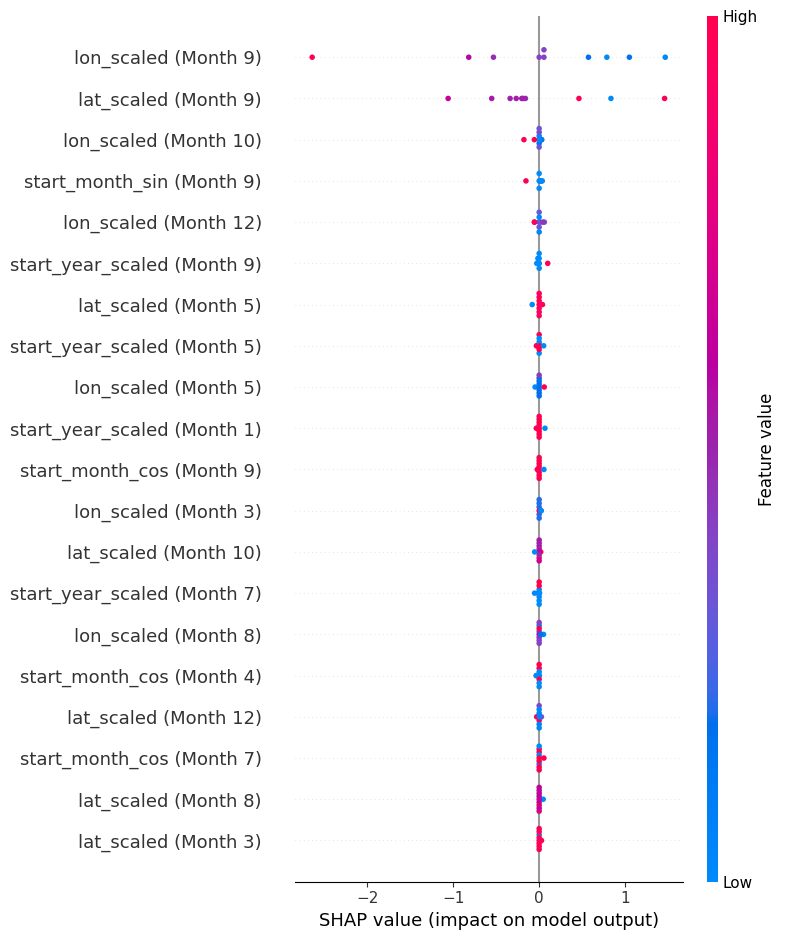


📊 SHAP Summary Plot — Month 10



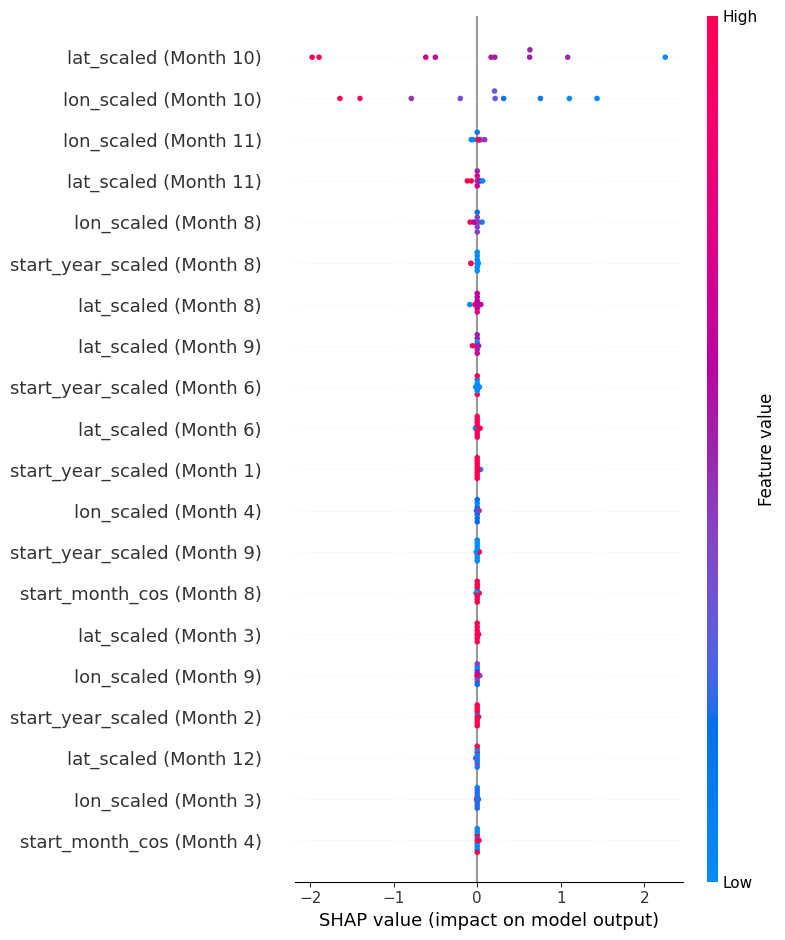


📊 SHAP Summary Plot — Month 11



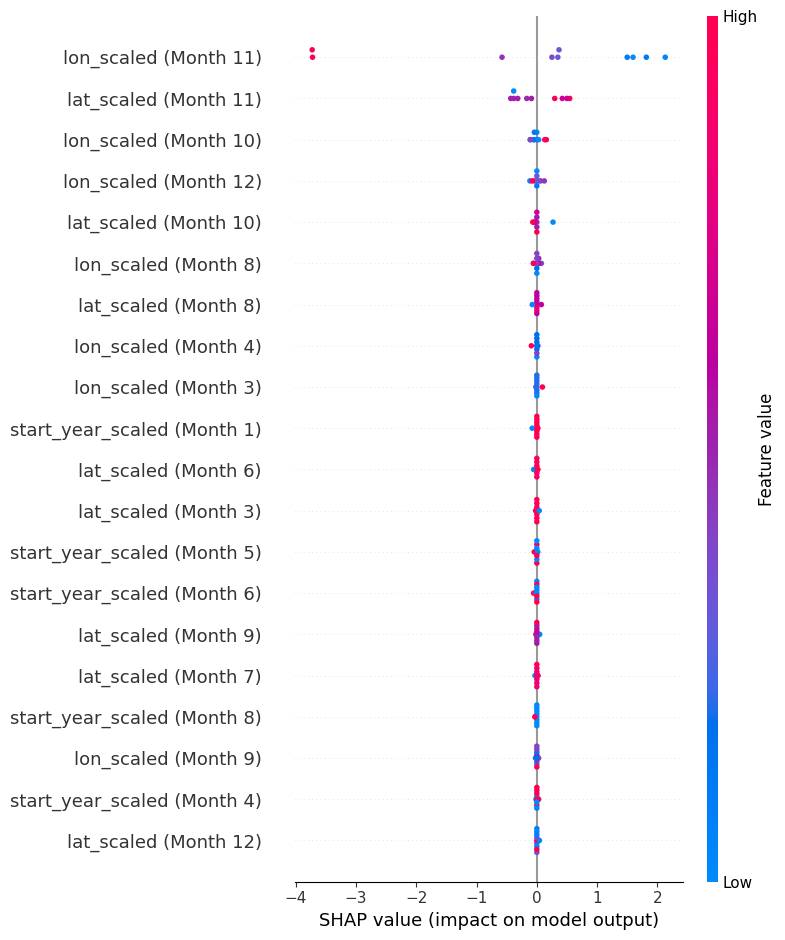


📊 SHAP Summary Plot — Month 12



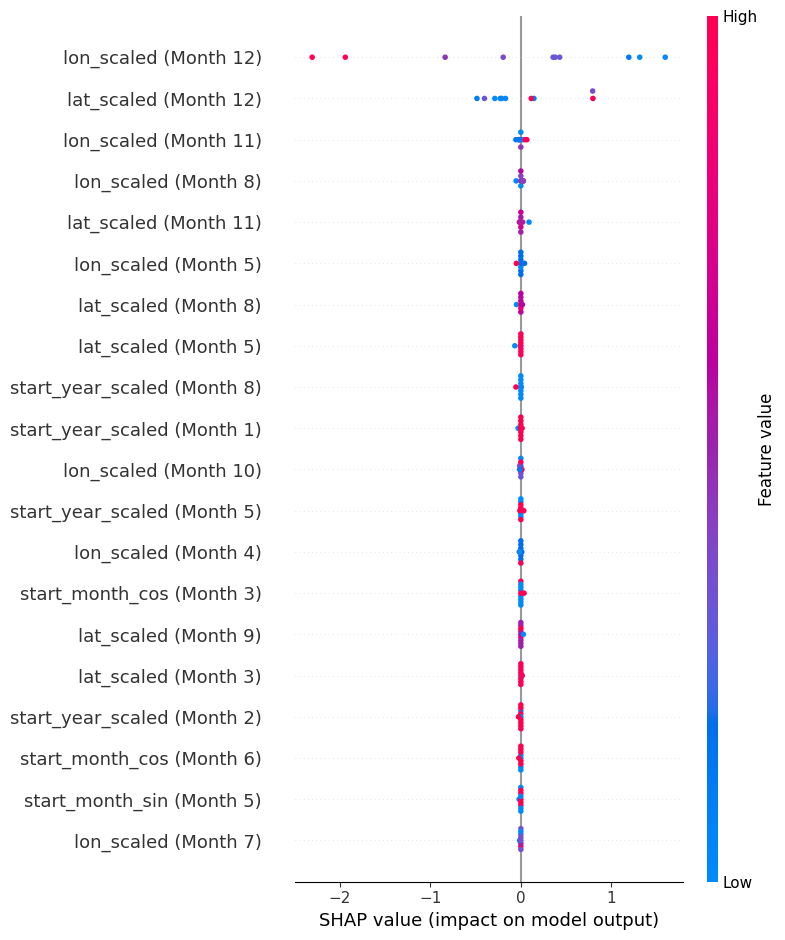

In [ ]:
for timestep in range(12):
    print(f"\n📊 SHAP Summary Plot — Month {timestep + 1}\n")
    shap.summary_plot(
        shap_values_num[:, :, timestep],
        num_data,
        feature_names=nice_feature_names,
        show=True
    )


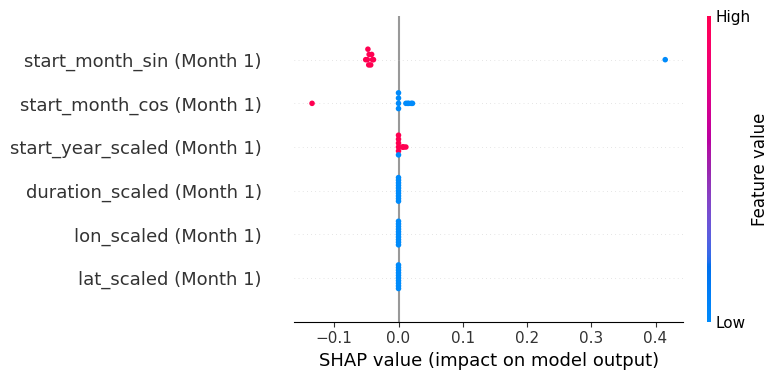

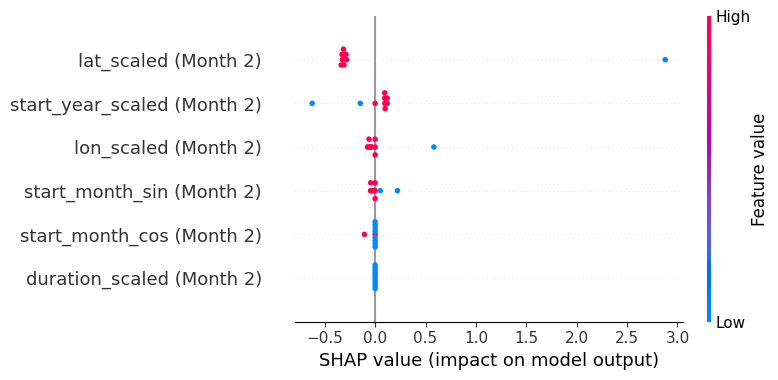

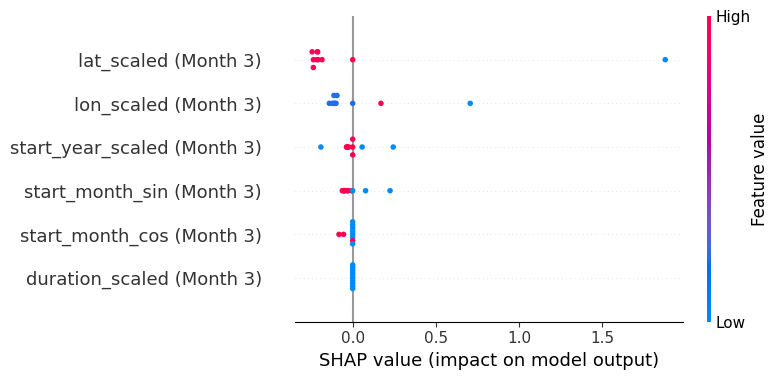

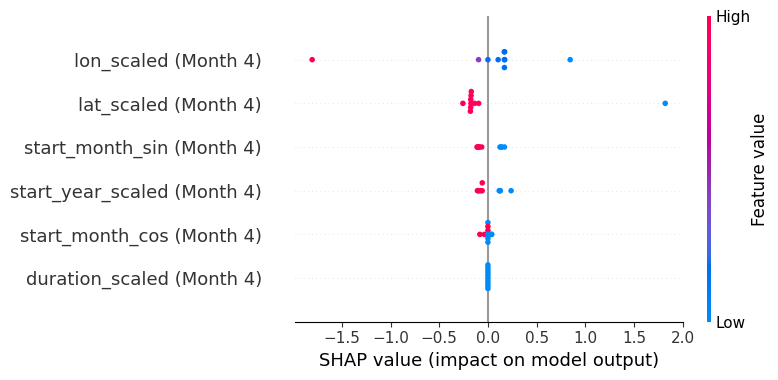

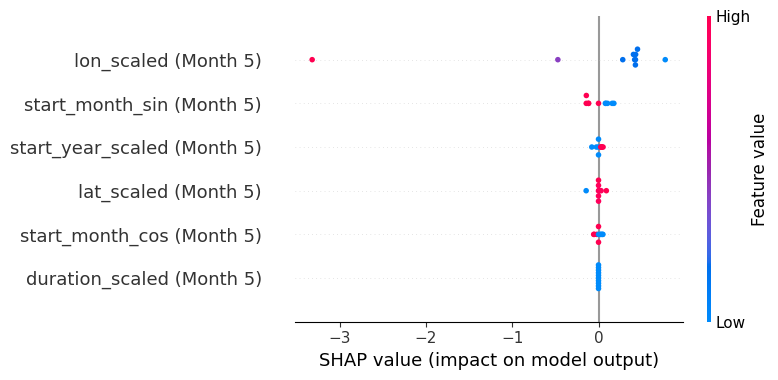

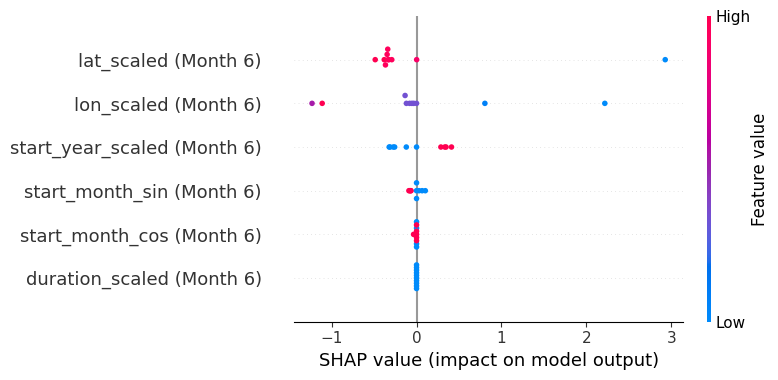

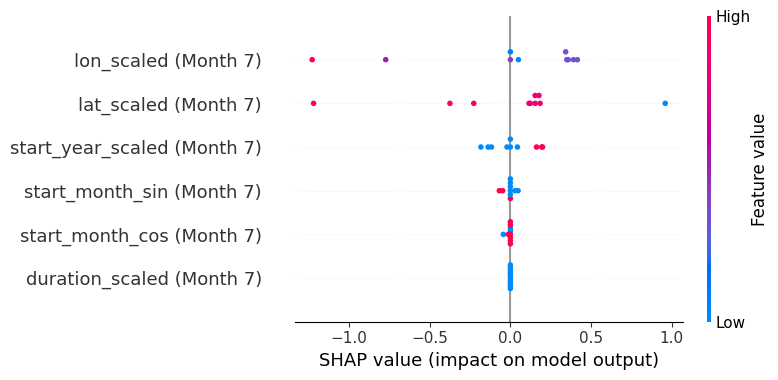

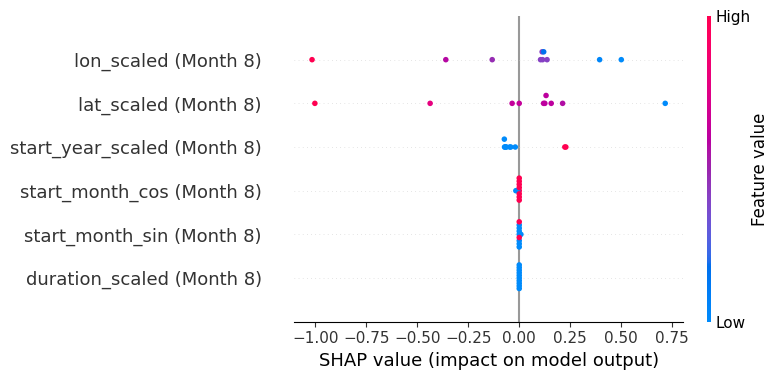

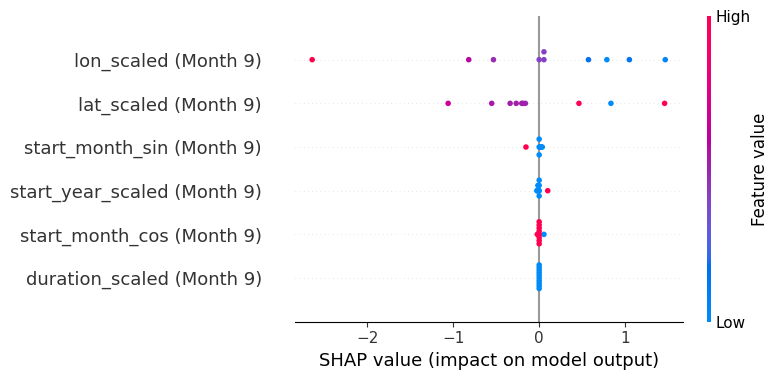

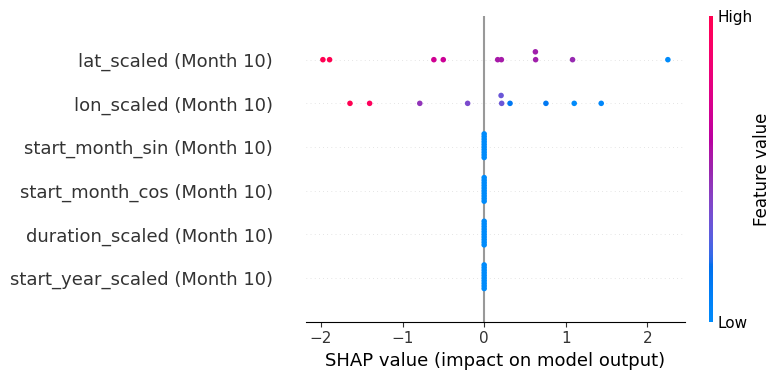

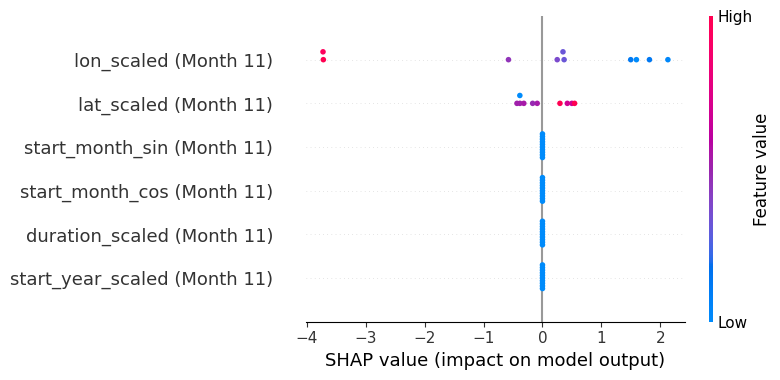

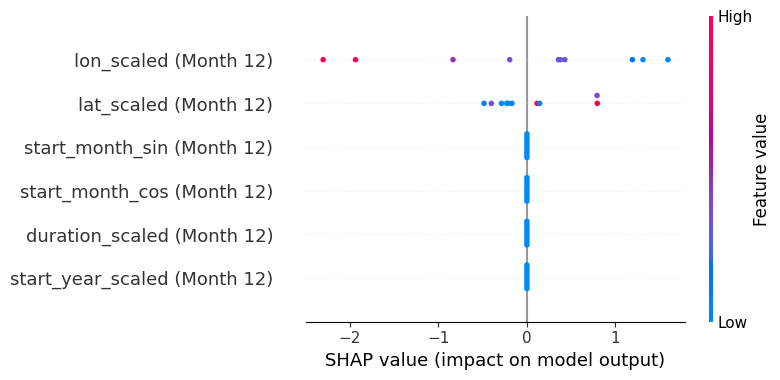

In [ ]:
for timestep in range(12):
    start = timestep * 6
    end = start + 6

    plt.figure()
    shap.summary_plot(
        shap_values_num[:, start:end, timestep],  # Only features for that month
        num_data[:, start:end],
        feature_names=[f"{col} (Month {timestep+1})" for col in numerical_feature_columns],
        show=True
    )

Creating SHAP PLOT FOR THE WHOLE YEAR

In [ ]:
# Create a dictionary to collect SHAP sums per feature
shap_sums = {col: np.zeros(num_batch.shape[0]) for col in numerical_feature_columns}

# For each feature, sum SHAP values across timesteps
for i, feature in enumerate(numerical_feature_columns):
    # Feature appears at positions: feature at t0, t1, ..., t11
    indices = [t * 6 + i for t in range(12)]  # 6 numerical features per timestep

    # Sum across those indices and also across all timesteps
    shap_sums[feature] = np.sum(shap_values_num[:, indices, :], axis=(1, 2))

# Now shap_sums contains a value per feature per sample.


In [ ]:
shap_means = {feat: np.mean(shap_sums[feat]) for feat in numerical_feature_columns}

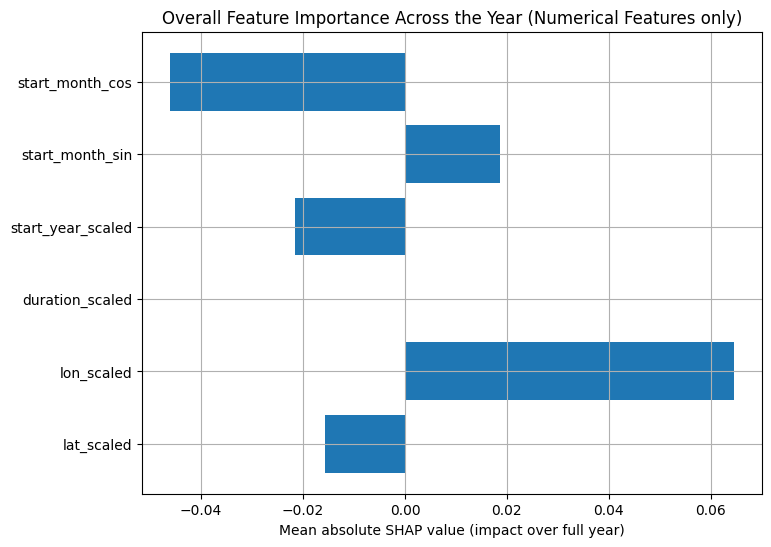

In [ ]:
plt.figure(figsize=(8, 6))
plt.barh(
    list(shap_means.keys()),
    list(shap_means.values())
)
plt.xlabel("Mean absolute SHAP value (impact over full year)")
plt.title("Overall Feature Importance Across the Year (Numerical Features only)")
plt.grid(True)
plt.show()

Force Plot

In [ ]:
sample_idx = 0

shap_sum_sample = {}
for i, feature in enumerate(numerical_feature_columns):
    indices = [t * 6 + i for t in range(12)]
    shap_sum_sample[feature] = np.sum(shap_values_num[sample_idx, indices, :])


In [ ]:
# Base value = expected model output (mean prediction) — we can approximate it
base_value = np.mean(model.predict([cat_batch, num_batch]))

# Feature values = mean value of each feature across 12 months for the sample
feature_vals = {}
for i, feature in enumerate(numerical_feature_columns):
    feature_vals[feature] = np.mean(num_batch[sample_idx, :, i])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [ ]:
shap.initjs()

shap.force_plot(
    base_value,
    np.array(list(shap_sum_sample.values())),
    feature_names=list(shap_sum_sample.keys()),
    features=np.array(list(feature_vals.values()))
)


In [ ]:
# ---------------------
# Save yearly SHAP attributions to JSON
# ---------------------

shap_yearly = shap_means  # Already has feature: value

output_path = "/content/drive/MyDrive/XAI/yearly_shap.json"

import json
with open(output_path, "w") as f:
    json.dump(shap_yearly, f, indent=4)

print(f"✅ Yearly SHAP attributions saved to {output_path}")

✅ Yearly SHAP attributions saved to /content/drive/MyDrive/XAI/yearly_shap.json
